In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings(action='ignore')

####  1. Выберите подвыборку с основными переменными для дальнейшего анализа.

In [4]:
path = "salary_data.csv"
source_df = pd.read_csv(path, engine="python", delimiter=";")

source_df.head(len(source_df))

,ID,income,age,gender,education_level
0,12182,86519.608537,45,M,2.0
1,81213,83085.864980,30,M,2.0
2,1996,82606.214973,22,M,2.0
3,9366,81551.229988,36,M,2.0
4,9733,79593.253224,51,M,1.0
...,...,...,...,...,...
99995,35271,15000.000000,38,M,1.0
99996,50709,15000.000000,20,M,0.0
99997,98689,15000.000000,32,F,0.0
99998,92169,15000.000000,21,M,2.0


Columns:
1. ID - Identifier of the candidate
2. incomde - The annual income declared by the person
3. age - Age of the person at the moment of the test
4. gender - Gender declared by the person
5. education_level - Education level declared by the user (0: primary complete, 1: secondary complete, 2: tertiary complete, 3: post


In [5]:
# стоит ли группировать по возрасту?
criteria = "ID"

def mean_amount_by_empl(df):
    df_empl = df.groupby(criteria, as_index=False).agg({"income": "mean"})
    df_empl = df_empl.sort_values("income", ascending=False)

    return df_empl

df_empl = mean_amount_by_empl(source_df)
df_empl.head()

,ID,income
45694,45694,285342.491970
13330,13330,195398.472324
59148,59148,187006.102853
46089,46089,182555.897397
75961,75961,181406.635439


In [6]:
count_empl = len(df_empl)
income_total = df_empl["income"].sum()

print("number of employees: {}".format(count_empl))
print("total income: {}".format(int(income_total)))

number of employees: 100000
total income: 4041251647


Text(0, 0.5, 'Income')

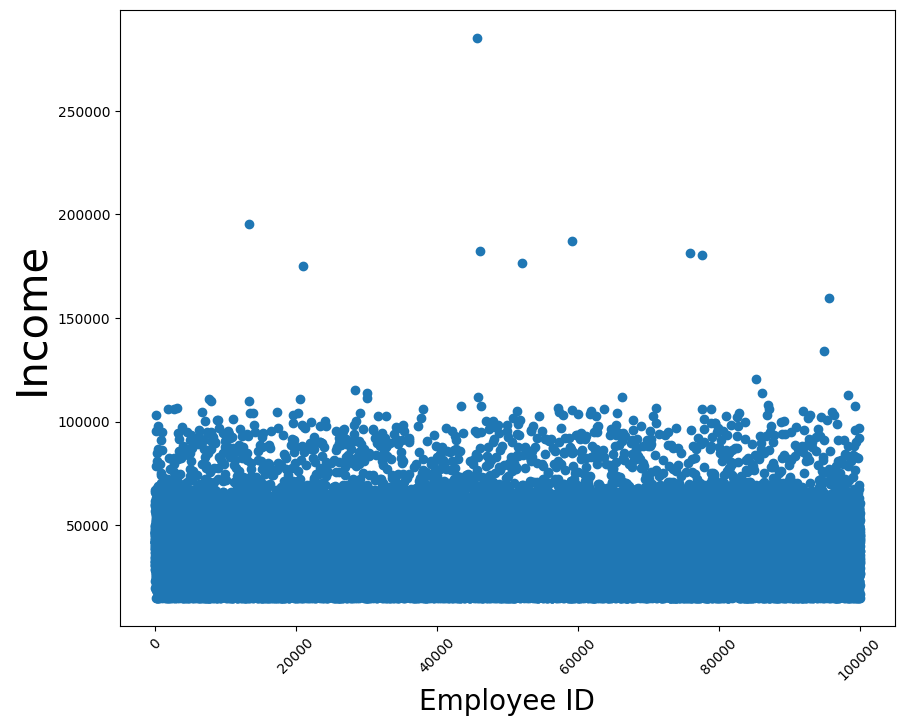

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(df_empl[criteria], df_empl["income"])
plt.xticks(rotation=45)

plt.xlabel(f"Employee {criteria}", fontsize=20)
plt.ylabel("Income", fontsize=30)



#### 2. Непараметрическая оценка плотности распределения в виде гистограммы с использованием функции плотности ядра

In [8]:
def cut_tails(array):
    array_cut = []
    q95, q05 = np.percentile(array, [95, 5])
    interval = q95 - q05
    
    min_dist = q05 - (1.5 * interval)
    max_dist = q95 + (1.5 * interval)
    
    for data in array:
        if data < max_dist and data > min_dist:
            array_cut.append(data)
    return array_cut

<AxesSubplot: >

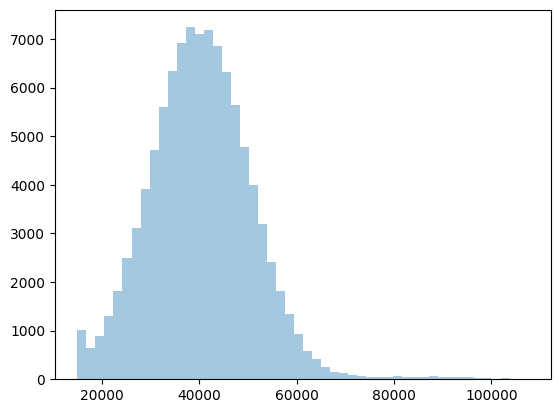

In [9]:
import seaborn as sns

sns.distplot(cut_tails(df_empl["income"]), kde=False)

In [10]:

mean = df_empl["income"].mean()
var = df_empl["income"].var()
std = df_empl["income"].std()
median = df_empl["income"].median()

trunk_mean = scipy.stats.trim_mean(df_empl["income"], proportiontocut=0.1)

def mad(df):
    sigma = 1.2
    k = scipy.stats.lognorm.ppf(3/4., s=sigma)
    median = df.median()

    return k * np.median(np.fabs(df - median))

mad_value = mad(df_empl["income"])
print(f'Average Income Size: Average = {int(mean)}, variance = {int(var)}, standard deviation = {int(std)},\n'
      f'median = {int(median)}, truncated mean {int(trunk_mean)}, MAD = {int(mad_value)}')

Average Income Size: Average = 40412, variance = 117306078, standard deviation = 10830,
median = 40097, truncated mean 40149, MAD = 15261


In [11]:
norm_q95 = scipy.stats.norm.ppf(0.95)
mean_conf = norm_q95 * std / np.sqrt(len(df_empl))

chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(df_empl) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(df_empl) - 1)

var_conf_left = var * (len(df_empl) - 1) / chi2_q95_left
var_conf_right = var * (len(df_empl) - 1) / chi2_q95_right

std_conf_left = np.sqrt(var_conf_left)
std_conf_right = np.sqrt(var_conf_right)

print("Sample mean: %0.3f +/- %0.3f" % (mean, mean_conf))
print("95%% Confidence interval of sample variance : (%0.3f; %0.3f)"
      % (var_conf_left, var_conf_right))
print("95%% Confidence interval of sample standard deviation: (%0.3f; %0.3f)"
      % (std_conf_left, std_conf_right))

Sample mean: 40412.516 +/- 56.336
95% Confidence interval of sample variance : (116284611.313; 118341126.508)
95% Confidence interval of sample standard deviation: (10783.534; 10878.471)


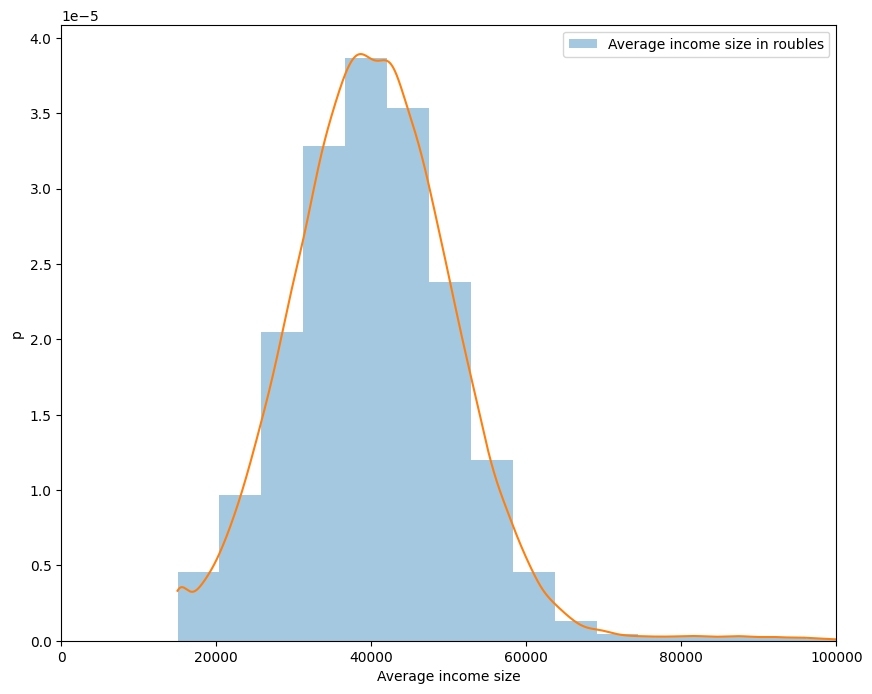

In [12]:
plt.figure(figsize=(10, 8))

kernel = scipy.stats.gaussian_kde(df_empl["income"])

min_price, max_price = df_empl["income"].min(), df_empl["income"].max()
x = np.linspace(min_price, max_price, len(df_empl))
kde_values = kernel.evaluate(x)

sns.distplot(df_empl["income"], kde=False, norm_hist=True, label="Average income size in roubles")
plt.plot(x, kde_values)

plt.ylabel("p")
plt.xlabel("Average income size")
plt.xlim(0, 10e4)
plt.legend()
plt.show()


In [13]:
all_ages = source_df["age"].unique()
print(sorted(all_ages))


[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69]


In [14]:
ages = [23, 25, 57]

df_ages = {age: source_df.loc[source_df["age"] == age] for age in ages}

for age in ages:
    print(f"number of respondents that age {age}: {len(df_ages[age])}")

number of respondents that age 23: 2519
number of respondents that age 25: 4292
number of respondents that age 57: 357


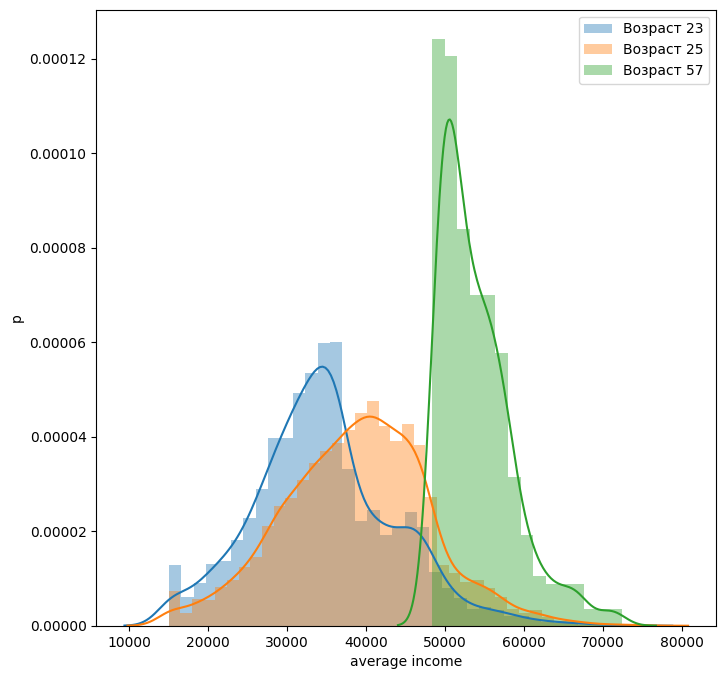

In [15]:
plt.figure(figsize=(8, 8))
for age, df_age in df_ages.items():
    sns.distplot(df_age["income"], kde=True, norm_hist=True, label=f'Возраст {age}')

plt.ylabel('p')
plt.xlabel('average income')
plt.legend()
plt.show()

#### 3. Вам необходимо провести оценку порядковых статистик и представить их в виде “ящиков с усами”.

      ID        income  age gender  education_level
0  12182  86519.608537   45      M              2.0
1  81213  83085.864980   30      M              2.0
2   1996  82606.214973   22      M              2.0
3   9366  81551.229988   36      M              2.0
4   9733  79593.253224   51      M              1.0


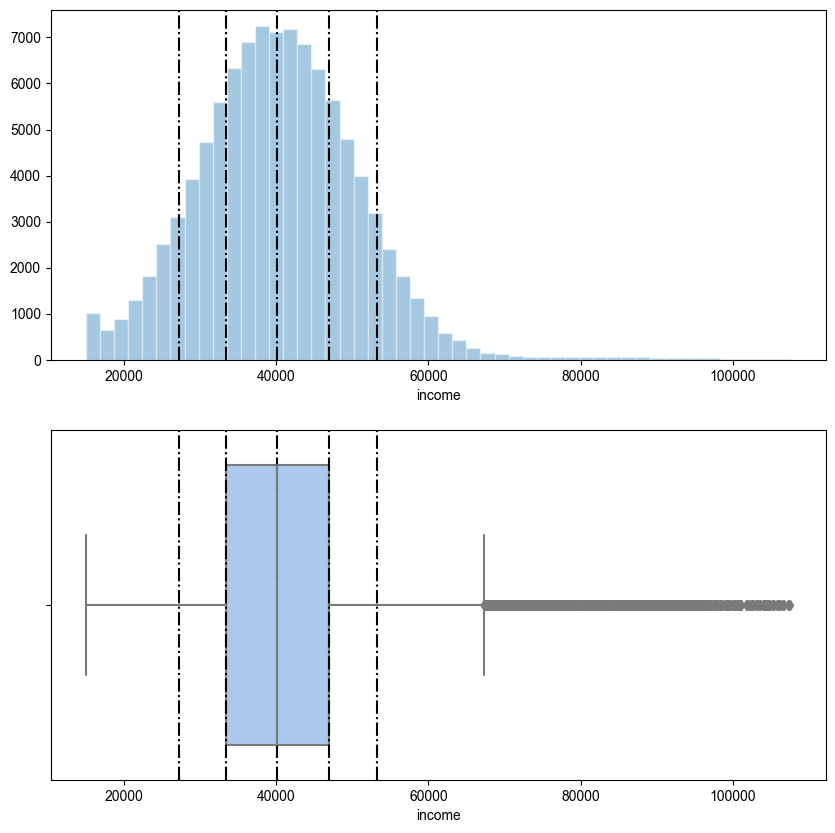

In [16]:
def quantiles(array):
    return np.array([np.quantile(array, percent) for percent in [0.1, 0.25, 0.5, 0.75, 0.9]])


def plot_box(array, label):
    figure, ax = plt.subplots(2, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    histplot = sns.distplot(array, ax=ax[0], kde=False)
    boxplot = sns.boxplot(x=array, ax=ax[1])

    histplot.set(xlabel=label)
    boxplot.set(xlabel=label)

    for quiantile in quantiles(array):
        ax[0].axvline(quiantile, color='black', linestyle='-.')
        ax[1].axvline(quiantile, color='black', linestyle='-.')
    
    plt.show()


print(source_df.head())
plot_box(cut_tails(source_df.income), 'income')

In [17]:
pd.Series(cut_tails(source_df.income)).describe()

count     99977.000000
mean      40388.617777
std       10696.200282
min       15000.000000
25%       33353.395689
50%       40095.016239
75%       46946.306645
max      107596.150830
dtype: float64

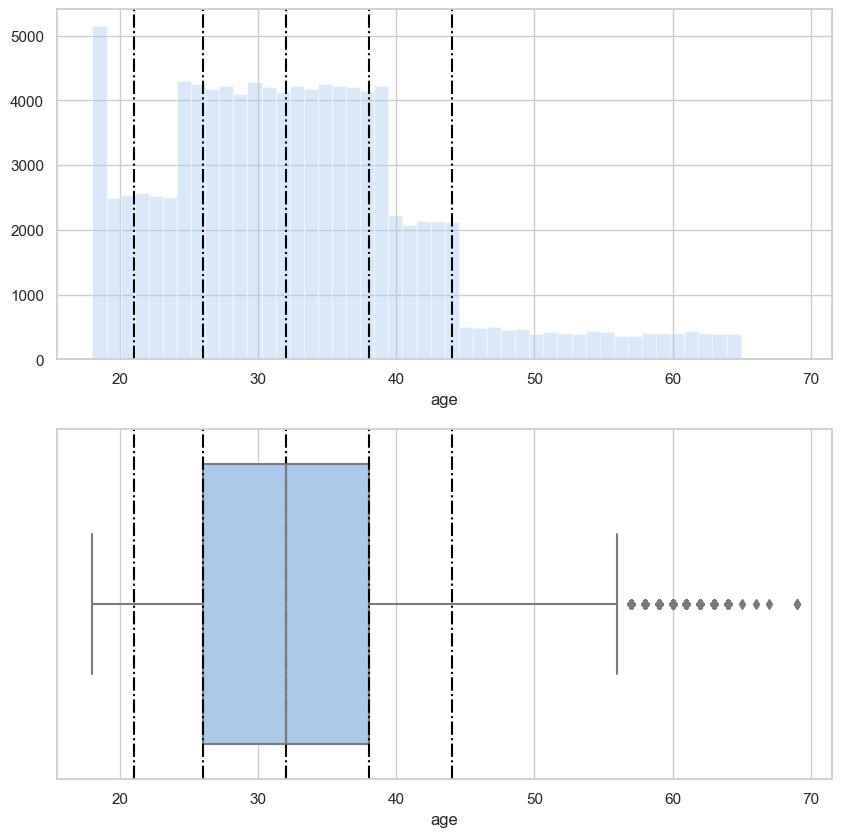

In [18]:
plot_box(cut_tails(source_df.age), 'age')

In [19]:
print(quantiles(source_df.age))
pd.Series(cut_tails(source_df.age)).describe()

[21. 26. 32. 38. 44.]


count    100000.000000
mean         32.971000
std           9.395403
min          18.000000
25%          26.000000
50%          32.000000
75%          38.000000
max          69.000000
dtype: float64

#### 4. Найдите одно или несколько теоретических распределений, которые могли бы описать вашу выборку на основе результатов непараметрического анализа.

In [20]:
methods = {type(d).__name__ : d for d in [
                    scipy.stats.norm, scipy.stats.alpha, scipy.stats.gamma,
                    scipy.stats.laplace, scipy.stats.beta, scipy.stats.gengamma 
                    ]}

def distplot(array, label):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    subplot = sns.distplot(array, kde=True)
    subplot.set(xlabel=label)


    for name, method in methods.items():
        x_plot = np.linspace(np.min(array), np.max(array), 100)
        args = method.fit(array)
        print(args)
        print("Method: ", name, "args: ", args)
        y_plot = method.pdf(x_plot, *args)
        
        sns.lineplot(x=x_plot, y=y_plot, label=name)
        plt.legend()

(40388.6177766022, 10696.146788838982)
Method:  norm_gen args:  (40388.6177766022, 10696.146788838982)
(12.875207437343263, -93240.2728211123, 1710293.4601254202)
Method:  alpha_gen args:  (12.875207437343263, -93240.2728211123, 1710293.4601254202)
(33.058858211188195, -20747.43558351221, 1849.3093158228817)
Method:  gamma_gen args:  (33.058858211188195, -20747.43558351221, 1849.3093158228817)
(40095.0162385597, 8245.179699978893)
Method:  laplace_gen args:  (40095.0162385597, 8245.179699978893)
(31.027084390189785, 23228.939358506563, -18971.538838950022, 44490771.648647346)
Method:  beta_gen args:  (31.027084390189785, 23228.939358506563, -18971.538838950022, 44490771.648647346)
(110.87537034920103, 0.6252732407508803, -29582.079066160237, 37.38822165453519)
Method:  gengamma_gen args:  (110.87537034920103, 0.6252732407508803, -29582.079066160237, 37.38822165453519)


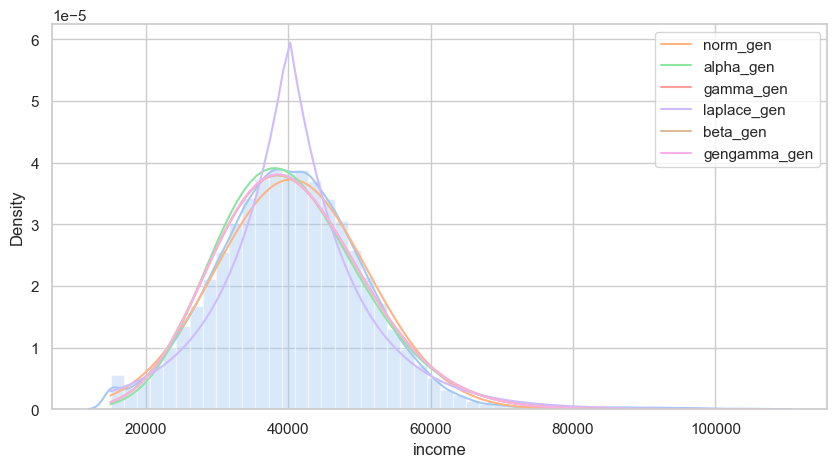

In [21]:
distplot(cut_tails(source_df.income), "income")

#### 5. Оценить параметры выбранных распределений, используя методы максимального правдоподобия и метод наименьших квадратов.

In [22]:
income_df = cut_tails(source_df.income)

for name, method in methods.items():
    mle = method.fit(data=income_df, method="MLE")

    print("({})args: ".format(name), mle)

    xdata, ydata = np.histogram(income_df, density=True)
    try:
        ls, _ = scipy.optimize.curve_fit(
            lambda x, a, b : getattr(scipy.stats.distributions, name[:-4]).pdf(x, a, b),
            xdata = xdata[:10],
            ydata = ydata[:10],
            method="lm"
            )
    except Exception as e:
        print("({})ERROR".format(name), e)
    else:
        print('({})Максимальное правдоподобие : {:.3f}, {:.3f}'.format(name, mle[0], mle[1]))
        print('({})Наименьшие квадраты: {:.3f}, {:.3f}'.format(name, ls[0], ls[1]))

(norm_gen)args:  (40388.6177766022, 10696.146788838982)
(norm_gen)Максимальное правдоподобие : 40388.618, 10696.147
(norm_gen)Наименьшие квадраты: -0.000, 0.000
(alpha_gen)args:  (12.875207437343263, -93240.2728211123, 1710293.4601254202)
(alpha_gen)Максимальное правдоподобие : 12.875, -93240.273
(alpha_gen)Наименьшие квадраты: 1.000, 1.000
(gamma_gen)args:  (33.058858211188195, -20747.43558351221, 1849.3093158228817)
(gamma_gen)Максимальное правдоподобие : 33.059, -20747.436
(gamma_gen)Наименьшие квадраты: 1.000, 1.000
(laplace_gen)args:  (40095.0162385597, 8245.179699978893)
(laplace_gen)ERROR Optimal parameters not found: Number of calls to function has reached maxfev = 600.
(beta_gen)args:  (31.027084390189785, 23228.939358506563, -18971.538838950022, 44490771.648647346)
(beta_gen)Максимальное правдоподобие : 31.027, 23228.939
(beta_gen)Наименьшие квадраты: 0.814, 39521.883
(gengamma_gen)args:  (110.87537034920103, 0.6252732407508803, -29582.079066160237, 37.38822165453519)
(gengam

#### 6. Проверьте оцененные параметры с помощью графика квантиль-квантиль (QQ).

In [23]:
def biplot(array, method):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sns.set_theme(style='whitegrid', palette='pastel')

    args = method.fit(array)
    print(f"({type(method).__name__})args: ", args)
    scipy.stats.probplot(array, dist=method, sparams=(args), plot=ax) # сравнение реального распределения данных с распределением method

    ax.get_lines()[0].set_marker('.')
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    plt.show()

(norm_gen)args:  (40388.6177766022, 10696.146788838982)


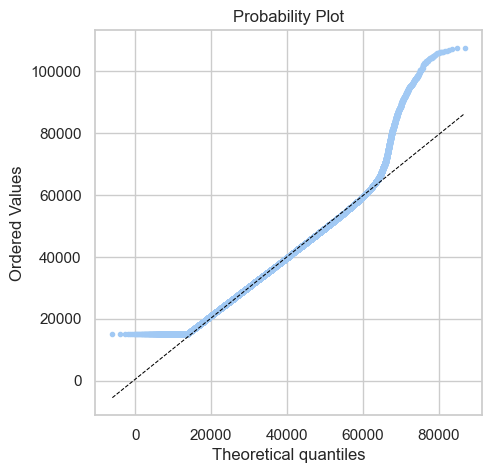

(alpha_gen)args:  (12.875207437343263, -93240.2728211123, 1710293.4601254202)


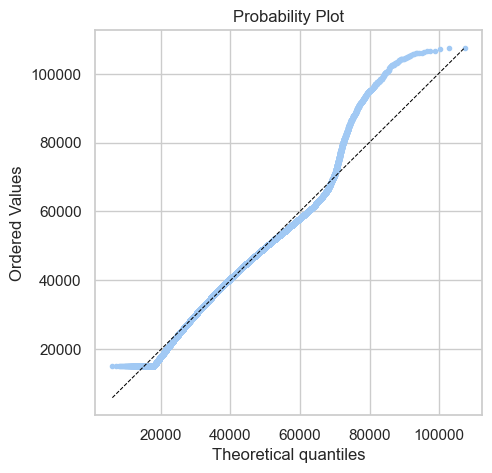

(gamma_gen)args:  (33.058858211188195, -20747.43558351221, 1849.3093158228817)


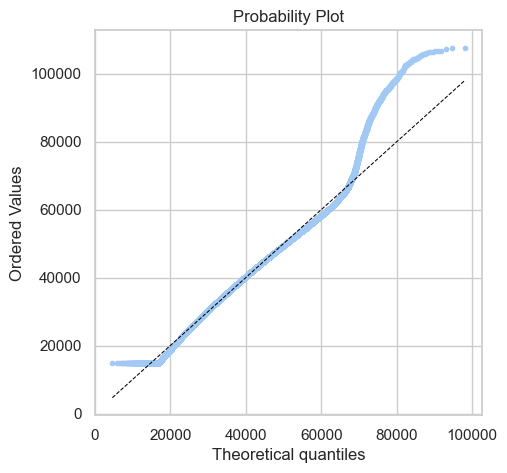

(laplace_gen)args:  (40095.0162385597, 8245.179699978893)


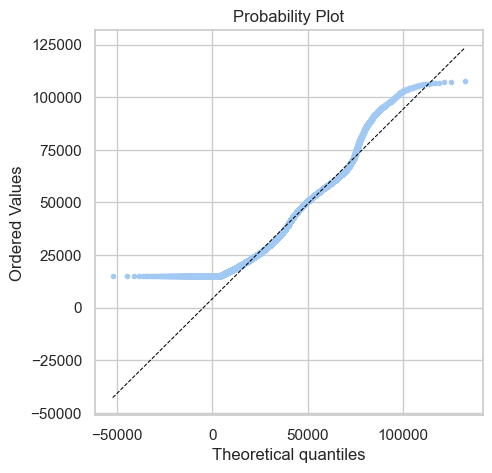

(beta_gen)args:  (31.027084390189785, 23228.939358506563, -18971.538838950022, 44490771.648647346)


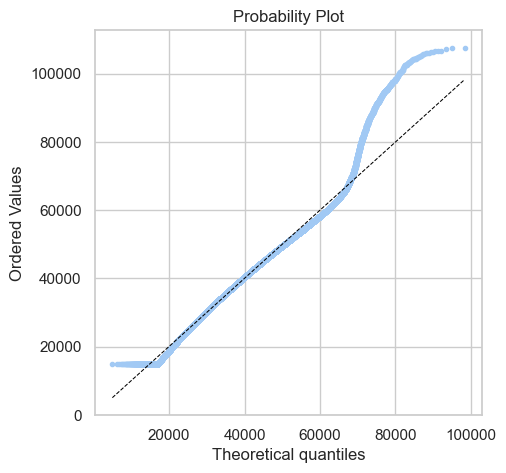

(gengamma_gen)args:  (110.87537034920103, 0.6252732407508803, -29582.079066160237, 37.38822165453519)


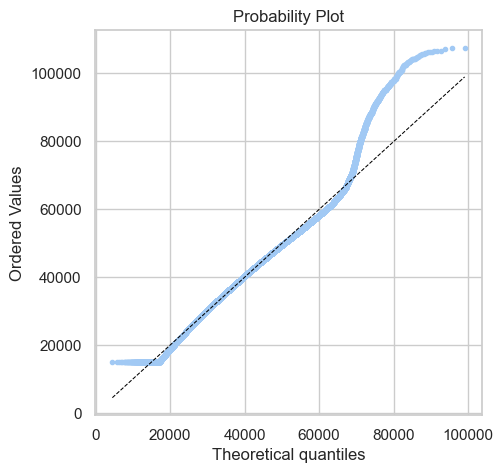

In [24]:
for m in methods.values():
    biplot(cut_tails(source_df.income), method=m)

#### 7. Оценить достоверность подогнанных распределений, используя не менее 2 статистических тестов.

In [54]:
def testing(array, method, cdf):
    args = method.fit(array)

    tests = (scipy.stats.shapiro, scipy.stats.kstest, scipy.stats.anderson)

    result = [
        ("shapiro", scipy.stats.shapiro(array)),
        ("kstest", scipy.stats.kstest(array, cdf=cdf, args=args)),
        ("anderson", scipy.stats.anderson(array)),
        ("cramervonmises", scipy.stats.cramervonmises(array, cdf=cdf, args=args)),
    ]

    return result
            
    


<AxesSubplot: >

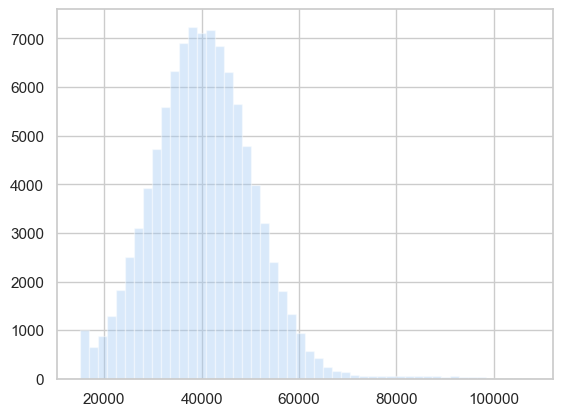

In [55]:
sns.distplot(cut_tails(source_df.income), kde=False)

In [56]:
for name, method in methods.items():
    cdf = name[:-4]
    test_res = testing(cut_tails(array=source_df.income), method=method, cdf=cdf)
    for k in test_res:
        print(f"({name} - {k[0]}): {k[1]}")

(norm_gen - shapiro): ShapiroResult(statistic=0.9754232168197632, pvalue=0.0)
(norm_gen - kstest): KstestResult(statistic=0.02033089613184913, pvalue=2.497253374035053e-36)
(norm_gen - anderson): AndersonResult(statistic=125.63396071719762, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(norm_gen - cramervonmises): CramerVonMisesResult(statistic=15.04744131483088, pvalue=2.0404935519025003e-09)
(alpha_gen - shapiro): ShapiroResult(statistic=0.9754232168197632, pvalue=0.0)
(alpha_gen - kstest): KstestResult(statistic=0.020335237341661372, pvalue=2.4106158387331096e-36)
(alpha_gen - anderson): AndersonResult(statistic=125.63396071719762, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(alpha_gen - cramervonmises): CramerVonMisesResult(statistic=18.023004846955704, pvalue=2.2525685761110026e-09)
(gamma_gen - shapiro): ShapiroResult(statistic=0.975423

#### 8. Используя одномерные параметрические распределения, которые были подобраны, выполните семплирование СВ. Используйте для этого не менее 2 различных методов семплирования.